In [1]:
import sys
sys.path.insert(1, '../')
import paths
import xarray
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rc
from scipy.signal import detrend
import numpy as np
import cartopy.crs as ccrs
from paths import FIGURE_IMAGE_OUTPUT

In [2]:
merra2_data = xarray.open_dataset(paths.RAW_MERRA2_DATA)
merra2_max = merra2_data.T2MMAX
merra2_min = merra2_data.T2MMIN

variance = lambda array : ((array - array.mean())**2).sum()/(len(array) - 1)

# <-- check if stack is needed or not
max_coeffs = merra2_max.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
min_coeffs = merra2_min.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()

In [3]:
# Linear De-trend
merra2_max_detrended = merra2_max - xarray.polyval(merra2_max.time, max_coeffs)
merra2_min_detrended = merra2_min - xarray.polyval(merra2_min.time, min_coeffs)

In [4]:
# Get mean year and find daily anomalies
merra2_max_anomalies = merra2_max_detrended.groupby("time.dayofyear") - merra2_max_detrended.groupby("time.dayofyear").mean()
merra2_min_anomalies = merra2_min_detrended.groupby("time.dayofyear") - merra2_min_detrended.groupby("time.dayofyear").mean()

In [5]:
# Calculate variance <- look for xarray function
variance = lambda array : ((array - array.mean())**2).sum()/(len(array) - 1)
merra2_max_variance = merra2_max_anomalies.stack(paired_points=['lat','lon']).groupby('paired_points').map(variance).unstack()
merra2_min_variance = merra2_min_anomalies.stack(paired_points=['lat','lon']).groupby('paired_points').map(variance).unstack()

In [6]:
trefhtmax_all_em = paths.get_paths_cdata()[3]
trefhtmin_all_em = paths.get_paths_cdata()[6]
all_max = xarray.open_dataset(trefhtmax_all_em[0]).TREFHTMX.sel(time=slice("1980","2015"))
all_min = xarray.open_dataset(trefhtmin_all_em[0]).TREFHTMN.sel(time=slice("1980","2015"))

In [7]:
max_coeffs = all_max.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
min_coeffs = all_min.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()

In [8]:
# Linear De-trend
all_max_detrended = all_max - xarray.polyval(all_max.time, max_coeffs)
all_min_detrended = all_min - xarray.polyval(all_min.time, min_coeffs)
# Get mean year and find daily anomalies
all_max_anomalies = all_max_detrended.groupby("time.dayofyear") - all_max_detrended.groupby("time.dayofyear").mean()
all_min_anomalies = all_min_detrended.groupby("time.dayofyear") - all_min_detrended.groupby("time.dayofyear").mean()
# Calculate variance
all_max_variance = all_max_anomalies.stack(paired_points=['lat','lon']).groupby('paired_points').map(variance).unstack()
all_min_variance = all_min_anomalies.stack(paired_points=['lat','lon']).groupby('paired_points').map(variance).unstack()

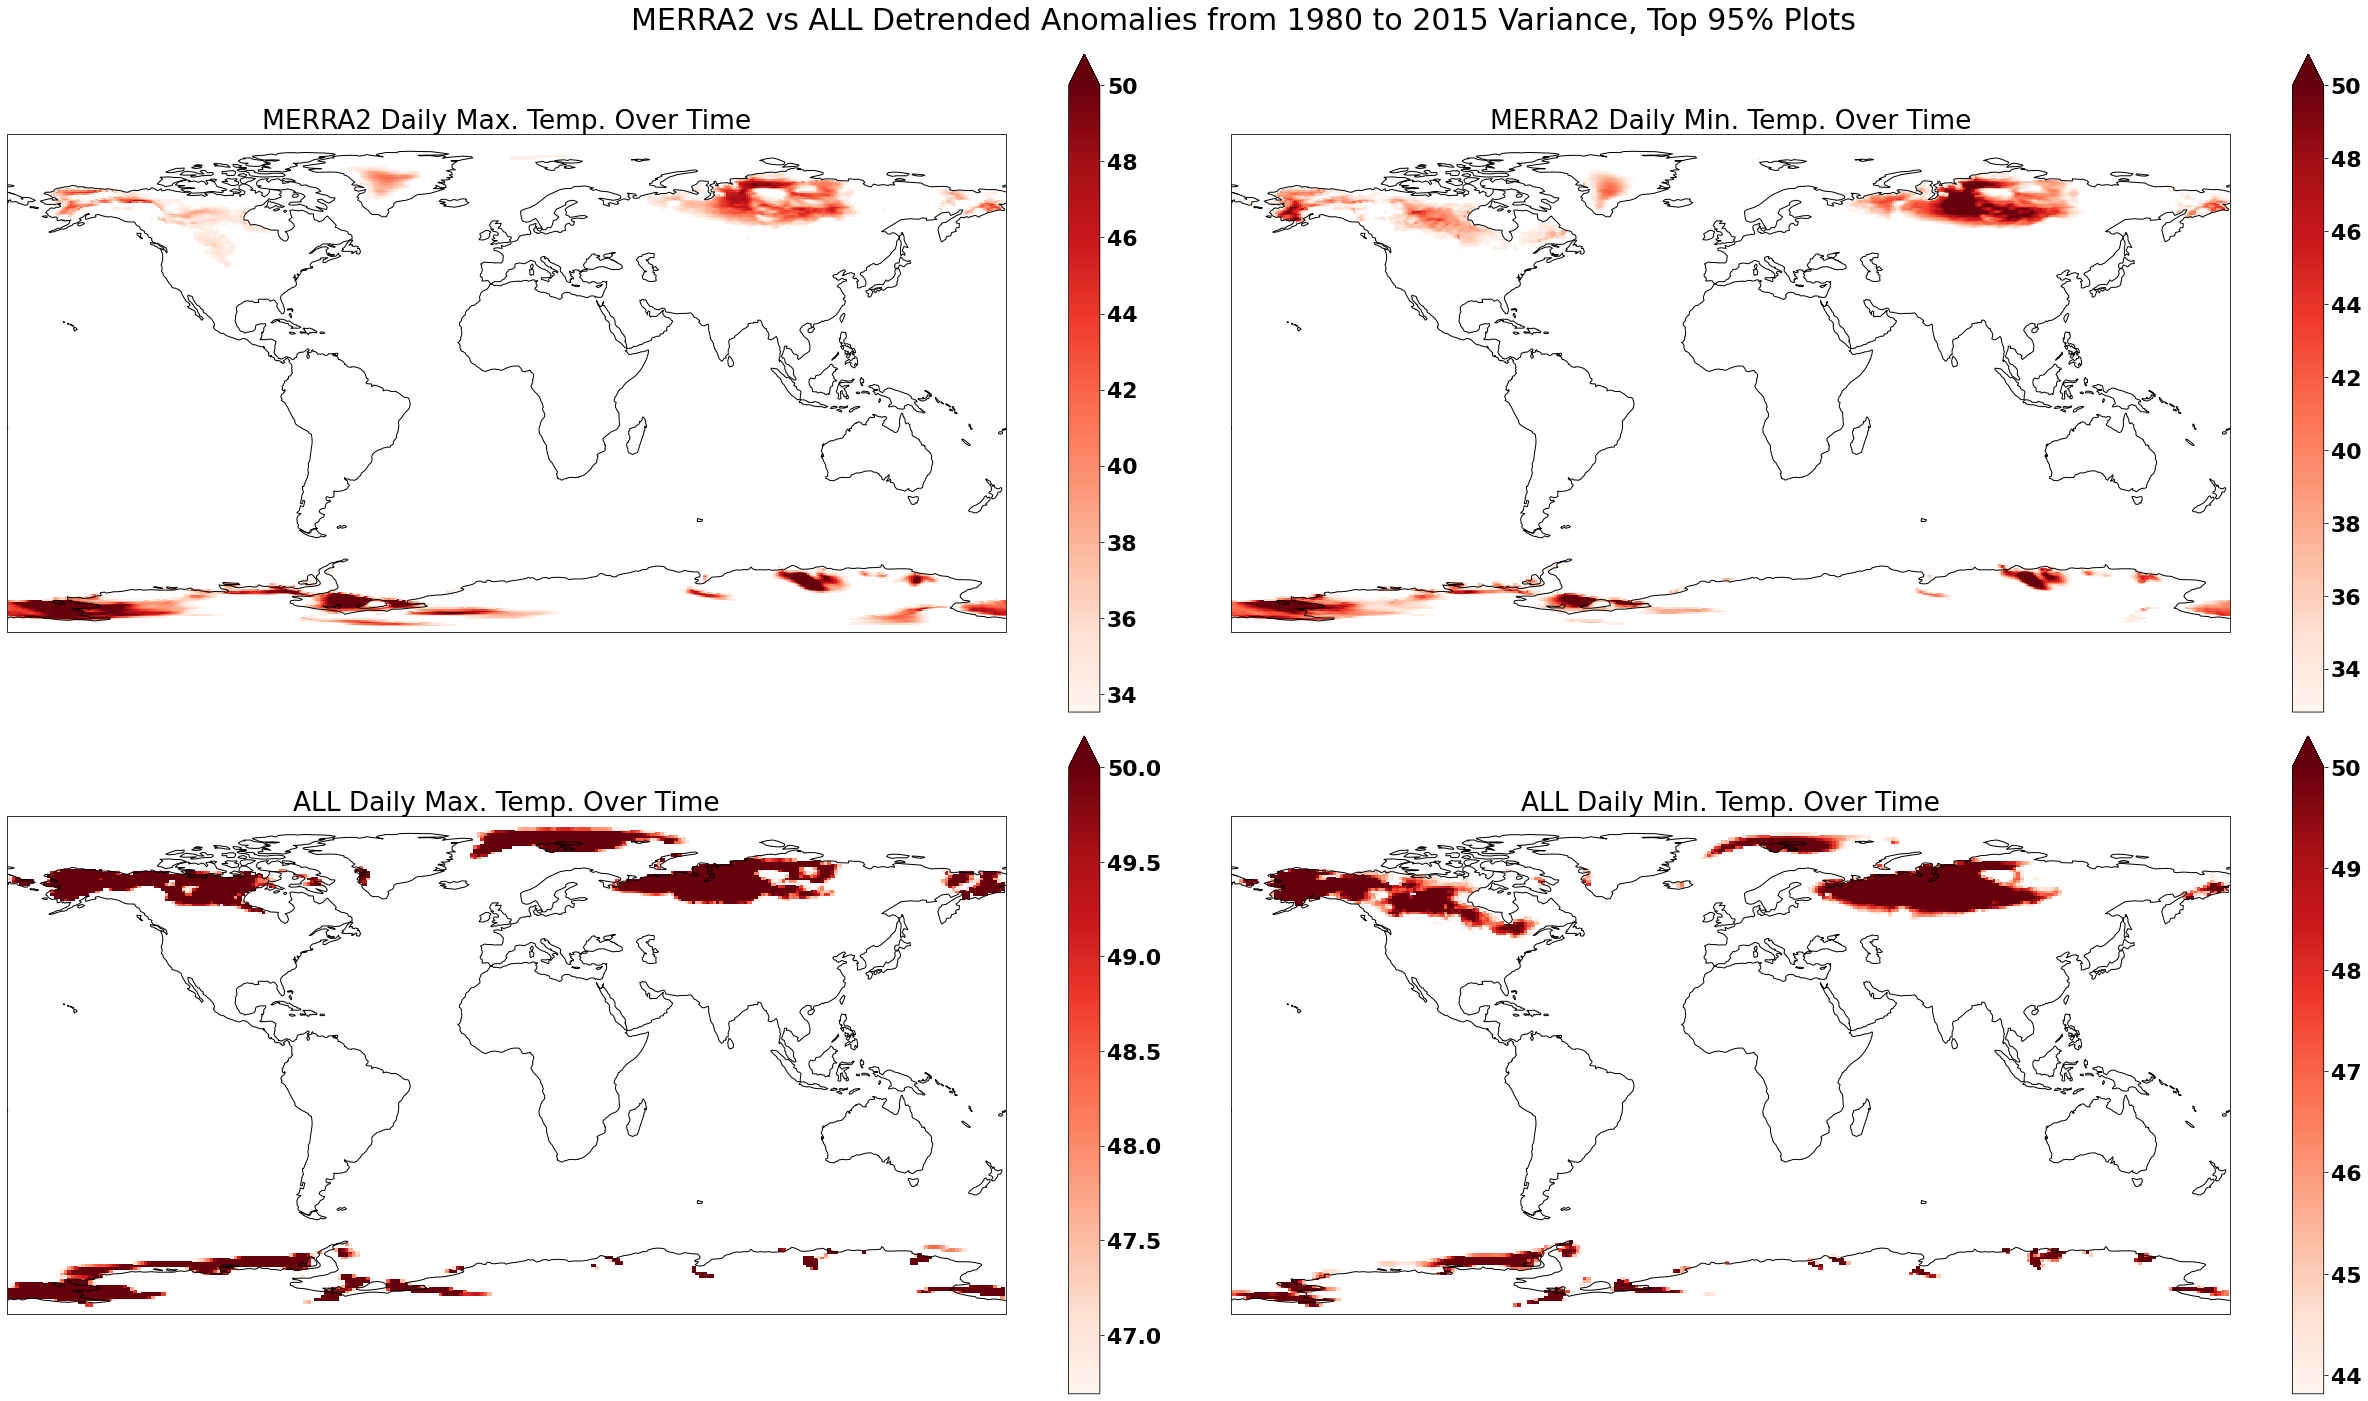

In [30]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35, 20), facecolor='w', subplot_kw=dict(projection=ccrs.PlateCarree()))
f.suptitle(f"MERRA2 vs ALL Detrended Anomalies from 1980 to 2015 Variance, Top 95% Plots", fontsize=30)
font = {'family': 'normal',
        'weight': 'bold',
        'size': 22}
rc('font', **font) #<---------------------- Do these calculations for ALL too
vmax = 50

merra2_max_variance.where(merra2_max_variance.quantile(0.95) <= merra2_max_variance).plot(ax=ax1, vmax=vmax, cmap='Reds')
ax1.set_title("MERRA2 Daily Max. Temp. Over Time")
ax1.coastlines()
merra2_min_variance.where(merra2_min_variance.quantile(0.95) <= merra2_min_variance).plot(ax=ax2, vmax=vmax, cmap='Reds')
ax2.set_title("MERRA2 Daily Min. Temp. Over Time")
ax2.coastlines()

all_max_variance.where(all_max_variance.quantile(0.95) <= all_max_variance).plot(ax=ax3, vmax=vmax, cmap='Reds')
ax3.set_title("ALL Daily Max. Temp. Over Time")
ax3.coastlines()
all_min_variance.where(all_min_variance.quantile(0.95) <= all_min_variance).plot(ax=ax4, vmax=vmax, cmap='Reds')
ax4.set_title("ALL Daily Min. Temp. Over Time")
ax4.coastlines()

f.tight_layout()

f.savefig(f"{FIGURE_IMAGE_OUTPUT}/MERRA2-ALL-Daily-Variance-Top95-Comparison.png")

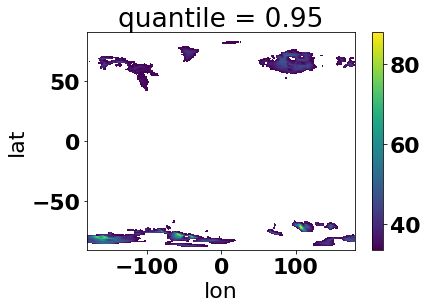

In [24]:
merra2_max_variance.where(merra2_max_variance >= merra2_max_variance.quantile(0.95)).plot()